# Rain Analysis
### Purpose
This notebook will look at volunteer trends for reporting rain, adressing the Github issue #54

### Author: 
Hamza El-Saawy
### Date: 
2020-06-14
### Update Date: 
2020-06-14

### Inputs 
 - `1.1-circles_to_many_stations_usa_weather_data_20200424213015`

### Output Files
`2.1-cbc_prcp_1900-2018.csv`: A reduced CBC dataset consisiting of only rain (precipitaion) data and an analysis of that data compared to the NOAA GHCN data

## Steps or Proceedures in the notebook 
 - Clean the CBC data
 - Compare to NOAA data
 - Make some plots

## Where the Data will Be Saved 
The project Google Drive, at: https://drive.google.com/drive/folders/1Nlj9Nq-_dPFTDbrSDf94XMritWYG6E2I

## Notes
the flattened NOAA BigQuery drops the `QFLAG` column, so we cannot drop erroneous data and also does not contain the `WT**` `element` values (which can be used alongside the `PRCP` fields to determin precipitation)

Additionally, 1.1 drops rows where `temp_min_value`, `temp_max_value`, `temp_avg`, and `snow` are `nan`, but they could have usable values for `[am|pm]_[rain|snow]`, since it is much easier to annotate if weather happened vs taking measurments.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# get the haversine distance formula fromt the script (w/o executing the '__main__' part)
%run -ni '../scripts/noaa.py'

The cleaned data set, `1.0-rec-initial-data-cleaning.txt`, drops circles with "impossible" temperture, wind, and snow values, which we still find valuable here since we assume that even mistaken/erroneous temp/wind data can still have valuable precipitation data

In [2]:
DATA_PATH = '../data/Cloud_Data'
RAW_DATA_PATH = os.path.join(DATA_PATH, 'cbc_effort_weather_1900-2018.txt')
CLN_DATA_PATH = os.path.join(DATA_PATH, '1.0-rec-initial-data-cleaning.txt')
NOAA_DATA_PATH = os.path.join(DATA_PATH, '1.1-circles_to_many_stations_usa_weather_data_20200617021358.txt')
CBC_PRCP_PATH = os.path.join(DATA_PATH, 'cbc_prcp_1900-2018.txt')

In [3]:
raw_data = pd.read_csv(RAW_DATA_PATH, encoding = "ISO-8859-1", sep="\t")

In [4]:
clean_data = pd.read_csv(CLN_DATA_PATH, encoding = "ISO-8859-1", sep="\t")

/home/hamza/anaconda3/envs/audubon/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
noaa_data = pd.read_csv(NOAA_DATA_PATH, encoding = "ISO-8859-1", sep="\t").rename(columns={'lat': 'c_lat', 'lon': 'c_lon', 
                                                                                           'id': 's_id', 'latitude': 's_lat', 'longitude': 's_lon'})

/home/hamza/anaconda3/envs/audubon/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (64,65) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


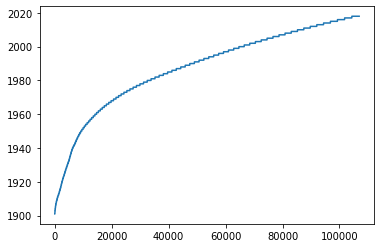

In [6]:
plt.plot(raw_data.count_year)

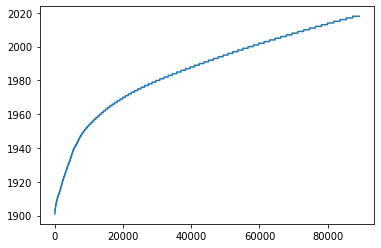

In [7]:
plt.plot(clean_data.count_year)

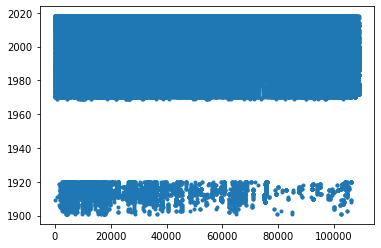

In [8]:
plt.plot(noaa_data.count_year, ".")

In [9]:
raw_data.country_state[raw_data.country_state.str.contains('us-', case=True)].value_counts()

us-wi    1042
us-ma      84
us-mn      64
us-fl       6
Name: country_state, dtype: int64

In [10]:
noaa_data.country_state[noaa_data.country_state.str.contains('us-', case=True)].value_counts()

Series([], Name: country_state, dtype: int64)

In [19]:
prcp_data = noaa_data.loc[:, ('count_date',
                              'circle_name', 'country_state', 'circle_id', 'c_lat', 'c_lon',
                              'min_snow_metric', 'am_rain', 'pm_rain', 'am_snow', 'pm_snow', 
                              's_id', 's_lat', 's_lon',
                              'precipitation_value', 'snow', 'snwd'
                             )]

## rain and snow monitoring

#### stations

In [21]:
# pd.NA preserved int-ness of bools, so they are not converted to floats, and supports three-valued (kleene) logic
prcp_data['s_snow'] = np.where(prcp_data.snow.isna(), pd.NA, prcp_data.snow > 0)

In [22]:
prcp_data['s_rain'] = np.where(prcp_data.precipitation_value.isna(), pd.NA, prcp_data.precipitation_value > 0)

#### volunteer records

`[am|pm]_[rain|snow]` are strings containing `1`:`4`, for heavy, light, none, or unknow rain or snow (respectively)  
If the string contains `4`, then -- regardless of observations in that string (e.g. `2,4`) -- it will be marked as `NaN`  
If the string contains either `1` or `2` in the am or pm, then there was precipitation that day  
If both am and pm are `3`, then there was no precipitation that day  
Else, we mark `nan`

In [23]:
for c in ['am_rain', 'pm_rain', 'am_snow', 'pm_snow']:
    prcp_data.loc[prcp_data[c].isna(), c] = pd.NA
    prcp_data.loc[prcp_data[c].str.contains('4', na=False), c] = pd.NA

In [24]:
prcp_data['c_rain'] = pd.NA

prcp_data.loc[(prcp_data.am_rain.str.contains('[12]', na=False) | prcp_data.pm_rain.str.contains('[12]', na=False)), 'c_rain'] = True
prcp_data.loc[((prcp_data.am_rain == '3') & (prcp_data.pm_rain == '3')), 'c_rain'] = False

In [25]:
prcp_data['c_snow'] = pd.NA

prcp_data.loc[(prcp_data.am_snow.str.contains('[12]', na=False) | prcp_data.pm_snow.str.contains('[12]', na=False)), 'c_snow'] = True
prcp_data.loc[((prcp_data.am_snow == '3') & (prcp_data.pm_snow == '3')), 'c_snow'] = False

## snow depth

#### volunteer records

In [26]:
prcp_data['c_sd_gtz'] = np.where(prcp_data.min_snow_metric.isna(), pd.NA, prcp_data.min_snow_metric > 0)

#### stations

In [27]:
prcp_data['s_sd_gtz'] = np.where(prcp_data.snwd.isna(), pd.NA, prcp_data.snwd > 0)

## distance between stations and circles

In [46]:
prcp_data['distance'] = prcp_data.apply(lambda tt: haversine_formula((tt.c_lat, tt.c_lon), (tt.s_lat, tt.s_lon)), axis=1)

# Analysis

In [48]:
prcp_data = prcp_data.loc[:, ['count_date', 
                              'circle_name', 'country_state', 'circle_id', 'c_lat', 'c_lon',
                              's_id', 's_lat', 's_lon', 'distance',
                              'c_rain', 'c_snow', 'c_sd_gtz',
                              's_snow', 's_rain', 's_sd_gtz',]]

undo the left join with the station so each circle/count data occurs once   
I am assumiong circle is unique for each date (no two circles overlapped with each other on the same date) and that no two circles with different lat/lons have the same id

In [86]:
circle_metadata = prcp_data[['circle_name', 'country_state', 'circle_id', 'c_lat', 'c_lon',]].groupby(['circle_id']).agg('first')
circle_obs = prcp_data[['count_date', 'circle_name', 'country_state', 'circle_id', 
                        'c_lat', 'c_lon','c_rain', 'c_snow', 'c_sd_gtz']].groupby(['circle_id', 'count_date']).agg('first')

In [99]:
station_obs = prcp_data[['count_date', 'circle_id', 
           's_id', 's_lat', 's_lon', 'distance',
           's_snow', 's_rain', 's_sd_gtz',]].set_index(['circle_id', 'count_date', 's_id'])

## Did it rain?

In [ ]:
prcp_data.c_rain.isna().sum()

In [ ]:
pd.Categorical(prcp_data.s_rain)

In [ ]:
pd.crosstab(prcp_data.s_rain, prcp_data.c_rain, dropna=False)

In [54]:
prcp_data.groupby(['circle_id', 'count_date']).agg({'s_rain': list})

s_rain
circle_id count_date                                                   
87ymqen   1971-12-27  [False, False, False, False, False, False, Fal...
          1973-12-15  [True, False, False, False, False, False, Fals...
          1974-12-27  [True, False, True, True, False, True, False, ...
          1975-12-20  [False, False, False, False, False, False, Fal...
          1976-12-19  [False, False, False, False, False, False, Fal...
...                                                                 ...
f2rdvu4   2015-12-19                                             [True]
          2016-12-17                                             [True]
          2017-12-16                                             [True]
zcpkrwz   1979-12-18                                             [True]
          1992-12-20                                             [<NA>]

[52725 rows x 1 columns]